In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch

import pandas as pd
import numpy as np
import scanpy as sc
import os
import yaml
from pathlib import Path


os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['R_HOME'] = 'D:/software/R/R-4.3.2'
os.environ['R_USER'] = 'D:/software/anaconda/anaconda3/envs/pt20cu118/Lib/site-packages/rpy2'
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='imputation', key_added_pred='impute_mclust',
             random_seed=666):
    """\
    Clustering using the mclust algorithm.
    The parameters are the same as those in the R package mclust.
    """

    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(adata.obsm[used_obsm], num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs[key_added_pred] = mclust_res
    adata.obs[key_added_pred] = adata.obs[key_added_pred].astype('int')
    adata.obs[key_added_pred] = adata.obs[key_added_pred].astype('category')
    return adata


In [2]:
import STMGAC

In [3]:
proj_name = 'MBA'
num_clusters = 52

In [4]:
with open('../Config/MBA.yaml', 'r', encoding='utf-8') as f:
    config = yaml.load(f.read(), Loader=yaml.FullLoader)

In [5]:
adata = sc.read_visium('D:/project/datasets/Mouse_Brain_Anterior_Section1',
                           count_file='filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

##### Load layer_guess label, if have
turth_path = 'D:/project/datasets/Mouse_Brain_Anterior_Section1/metadata.tsv'
truth_labels = pd.read_csv(turth_path, sep='\t', header=0)
truth_labels.index = adata.obs_names
adata.obs['layer_guess'] = truth_labels['ground_truth']
adata = adata[~pd.isnull(adata.obs['layer_guess'])]

graph_dict = STMGAC.graph_construction(adata, config['data']['k_cutoff'])

adata.layers['count'] = adata.X.toarray()
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count',
                            n_top_genes=config['data']['top_genes'])
adata = adata[:, adata.var['highly_variable'] == True]
sc.pp.scale(adata)

adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
adata.obsm['X_pca'] = adata_X

In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net = STMGAC.Mgac(adata, graph_dict=graph_dict, num_clusters=num_clusters, device=device, config=config)

In [7]:
net.trian()

Epoch 499 total loss=0.961 recon loss=0.519 mean loss=0.564 tri loss=0.387: 100%|██████████| 500/500 [00:17<00:00, 28.41it/s]


In [8]:
enc_rep, recon = net.process()
enc_rep = enc_rep.data.cpu().numpy()
recon = recon.data.cpu().numpy()
adata.obsm['latent'] = enc_rep
adata.obsm['recon'] = recon


In [9]:
adata = mclust_R(adata, num_cluster=num_clusters, used_obsm='latent', key_added_pred='mclust')
adata.obs['domain'] = STMGAC.refine_label(adata, 30, key='mclust')
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
ARI = ari_score(sub_adata.obs['layer_guess'], sub_adata.obs['domain'])
ARI

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


0.5468304317209085

[<Axes: title={'center': 'layer_guess'}, xlabel='spatial1', ylabel='spatial2'>]

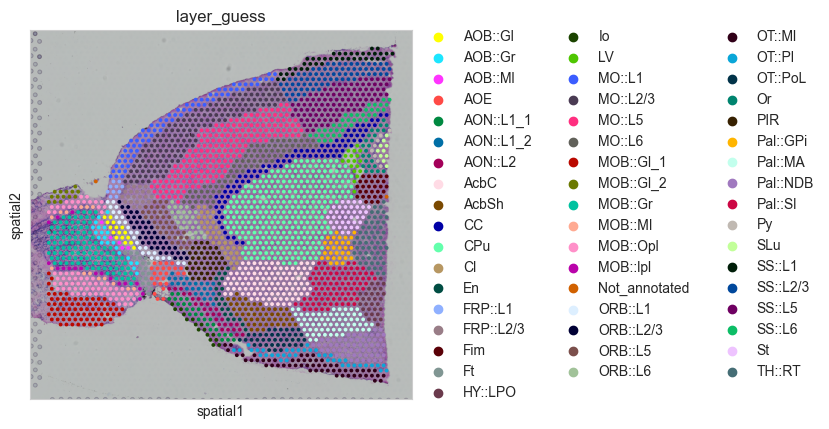

In [10]:
sc.pl.spatial(adata, color=['layer_guess'], show=False)

[<Axes: title={'center': 'domain'}, xlabel='spatial1', ylabel='spatial2'>]

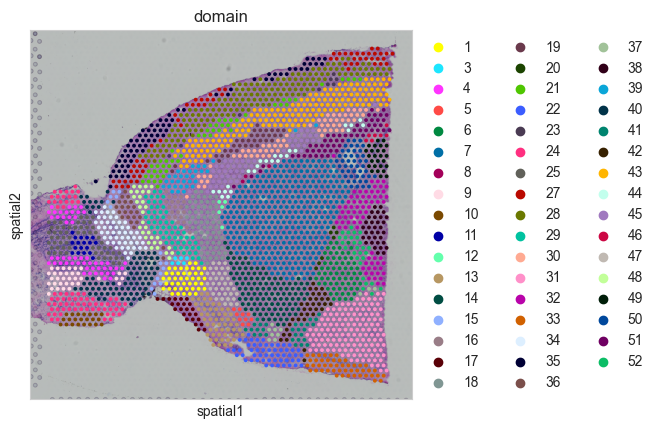

In [11]:
sc.pl.spatial(adata, color=['domain'], show=False)